# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.1551283152773424

In [8]:
# 18:56

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [10]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


15/15 [==============================] - 1s 13ms/step - loss: -0.0038 - val_loss: -0.0317
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0317 - val_loss: -0.0507
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0466 - val_loss: -0.0613
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0553 - val_loss: -0.0678
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0598 - val_loss: -0.0719
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0637 - val_loss: -0.0751
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0665 - val_loss: -0.0776
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0688 - val_loss: -0.0797
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0712 - val_loss: -0.0819
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0735 - val_loss: -0.0840


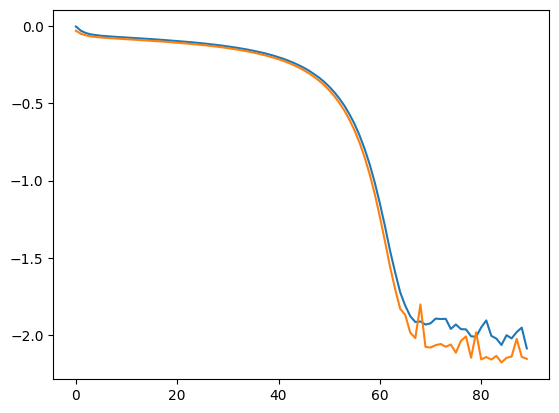

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [14]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 1s 746us/step


In [15]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

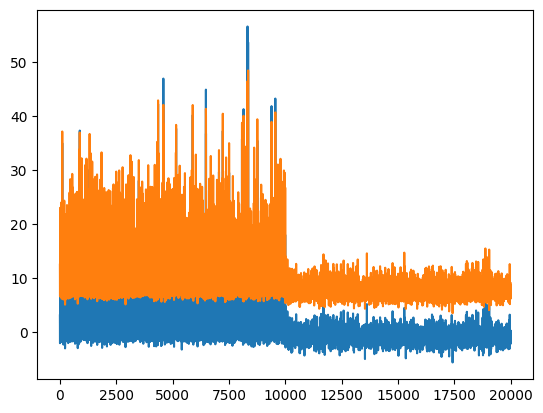

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

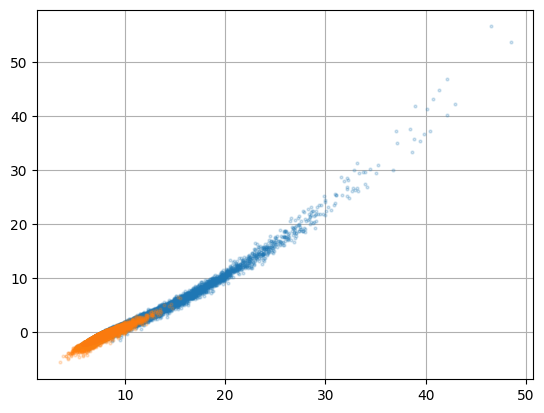

In [17]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

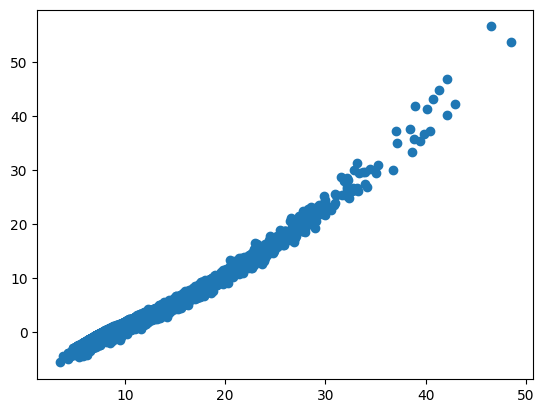

In [18]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [19]:
DV_fun(y, t_x_pred)

1.9983473939516188

In [20]:
DV_fun(y, t_x_opt)

2.1551283152773424

In [21]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [22]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

141/625 [=====>........................] - ETA: 0s

625/625 [==============================] - 0s 685us/step


In [23]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [24]:
DV_fun(y_new, t_x_pred)

2.207788761820707

In [25]:
DV_fun(y_new, t_x_opt)

2.3478724796431267

### f)

In [29]:
def NWJ_loss(y_true, y_pred):
    first_term = tf.reduce_mean(y_pred[y_true==1])
    second_term = tf.reduce_mean(tf.math.exp(y_pred[y_true==0]-1))
    return  -(first_term - second_term)

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.2190 - val_loss: 0.0588
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.0052
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0142 - val_loss: -0.0264
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0384 - val_loss: -0.0462
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0536 - val_loss: -0.0595
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0642 - val_loss: -0.0690
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0717 - val_loss: -0.0757
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0777 - val_loss: -0.0811
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0819 - val_loss: -0.0859
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0862 - val_loss: 

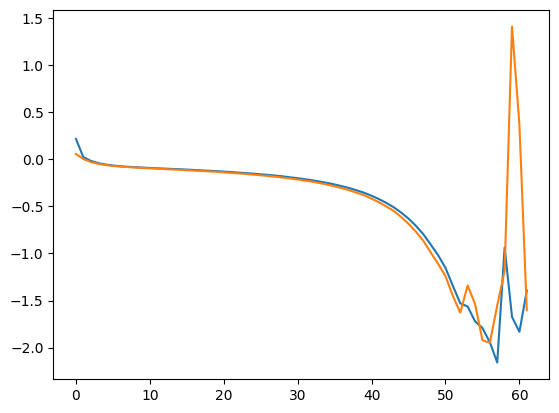

In [31]:
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

# HOMEWORK - just f)
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model2 = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model2.compile(optimizer=optimizer, loss=NWJ_loss)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

hist = model2.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

625/625 [==============================] - 0s 646us/step


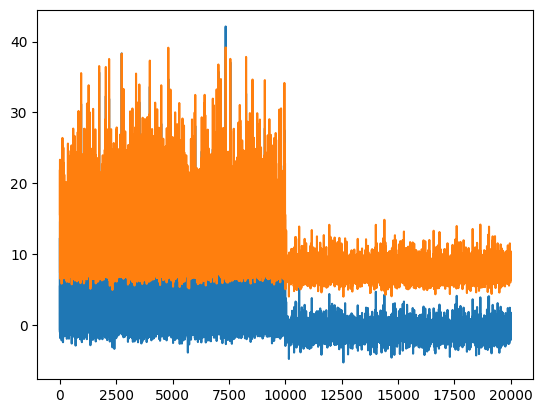

In [32]:
t_x_pred = model.predict(x)[:,0]
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

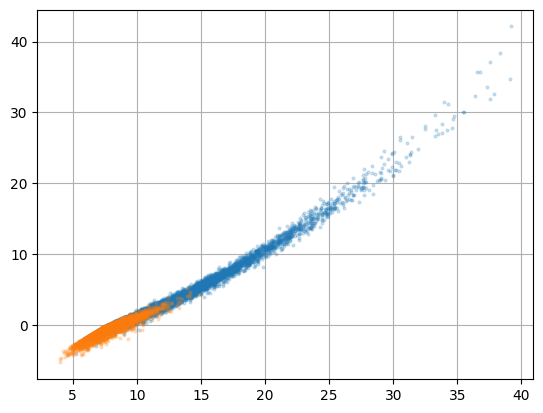

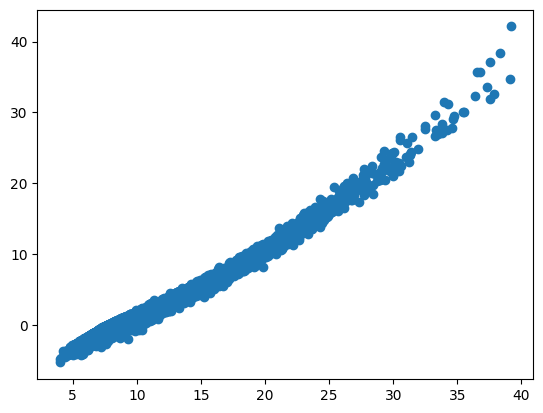

In [33]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()